<a href="https://colab.research.google.com/github/hane94/Machine-Learning-Practice/blob/master/lesson6_rossmann(hyeseon).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [0]:
path = Path('/content/drive/My Drive/Colab Notebooks/Lesson6/rossmann')
train_df = pd.read_pickle(path/'train_clean')

In [14]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [15]:
n = len(train_df); n

844338

### Experimenting with a sample

In [0]:
idx = np.random.permutation(range(n))[:2000] #grab 2000 random id
idx.sort()
small_train_df = train_df.iloc[idx[:1000]] #training set
small_test_df = train_df.iloc[idx[1000:]] #test set
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity'] #grab 5 columns
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [19]:
small_train_df.head() #pandas missing - NaN

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
18,19,5,"Mar,Jun,Sept,Dec",3240.0,61,8234
200,201,5,"Mar,Jun,Sept,Dec",20260.0,61,6625
878,881,5,"Feb,May,Aug,Nov",180.0,61,7396
904,907,5,NaN,250.0,61,8485
1068,1071,5,"Mar,Jun,Sept,Dec",820.0,61,7241


In [20]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
399191,824,6,NaN,17570.0,73,4706
399283,916,6,NaN,90.0,69,5632
399776,295,5,"Mar,Jun,Sept,Dec",210.0,55,4226
399861,380,5,"Mar,Jun,Sept,Dec",2240.0,64,12107
399974,493,5,"Jan,Apr,Jul,Oct",1150.0,64,6094


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars) #string -> numbers
categorify(small_train_df)
categorify(small_test_df, test=True) #use same category

In [22]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
399191,824,6,NaN,17570.0,73,4706
399283,916,6,NaN,90.0,69,5632
399776,295,5,"Mar,Jun,Sept,Dec",210.0,55,4226
399861,380,5,"Mar,Jun,Sept,Dec",2240.0,64,12107
399974,493,5,"Jan,Apr,Jul,Oct",1150.0,64,6094


In [23]:
small_train_df.PromoInterval.cat.categories #categories in pandas

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [24]:
small_train_df['PromoInterval'].cat.codes[:5] #실제로 저장된 숫자들 여기서 -1은 NaN을 나타냄(pandas에서는,-1을 missing의 의미로 사용)

18      2
200     2
878     0
904    -1
1068    2
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [26]:
small_train_df[small_train_df['CompetitionDistance_na'] == True] #create an additional column / replace competition distance with the median

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
88712,879,1,"Feb,May,Aug,Nov",2260.0,68,5503,True
263525,622,1,NaN,2260.0,75,5801,True
350943,291,4,NaN,2260.0,71,8849,True


### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [28]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize] 

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw'] #categorical variables

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday'] #continuous variables

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy() #df = data frame / training set[categorical variables,continuous variables]+dependent variables 

In [32]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [33]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [35]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True) #List of Float, not categories
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

TabularList - standard datablock API

In [0]:
doc(FloatList)

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2) #make the range wider
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, #overfitting을 막기 위해 layer의 파라미터를 줄일 것이 아니라, regularization을 해줄 것
                        y_range=y_range, metrics=exp_rmspe) #weight decay를 이용 / ps => dropout을 제공 / emb_drop : embedding dropout

dropout : a kind of regularizion
램덤하게 액티베이션의 퍼센티지를 버리는 것 

파라미터나 가중치에 변화를 주는 것이 아님

test time에서는 dropout X
test time = inference time

ps = [0.001,0.01] dropout값, 첫번째 레이어와 그 다음레이어의 드랍아웃값을 의미

embedding layer에는 emb_drop을 이용해 별도의 드랍아웃값을 지정

In [40]:
learn.model #whole bunch of embeddings (number of levels of the input,)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [41]:
len(data.train_ds.cont_names)

16

In [44]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


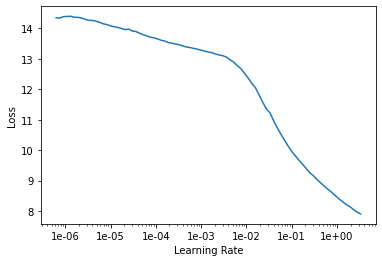

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.025073,0.021176,0.138754,04:17
1,0.019620,0.017343,0.125334,04:18
2,0.018352,0.015418,0.120099,04:13
3,0.012775,0.014793,0.126189,04:20
4,0.011642,0.010901,0.104495,04:20


In [0]:
learn.save('1')

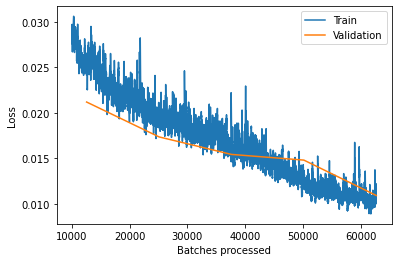

In [48]:
learn.recorder.plot_losses(skip_start=10000)

In [0]:
learn.load('1');

In [50]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012095,0.013111,0.115331,04:15
1,0.011932,0.022976,0.120785,04:16
2,0.011038,0.012258,0.109817,04:17
3,0.009727,0.013809,0.116065,04:17
4,0.009283,0.013024,0.114404,04:17


In [51]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010347,0.013868,0.123368,04:18
1,0.011808,0.016036,0.122536,04:18
2,0.011063,0.015091,0.123544,04:17
3,0.009367,0.017867,0.128004,04:16
4,0.009110,0.022194,0.128452,04:13


(10th place in the competition was 0.108)

In [52]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)